# Time series analysis for financial markets


The purpose of this article is to give a brief overview of usual times series analysis techniques. Methods are not presented rigourously, since the intention is to show how powerful and handy python libraries are in data analysis. Furthermore, as this article has been thought as a continuation of binomial asset-pricing model, we use GARCH(1,1) model for estimating daily volatility during 2009 and apply these results to option pricing.

#### What is a time series? 

It is simply a sequence of information which attaches a **precise date to each value**. Therefore, they satisfy two pecularities: 

- Intervals are identical. For instance, one day. 
- Chronological order is always preserved. 

Typical examples of time series are **stock market prices, meteorological records, business sales or number of students that pass an exam each year**. With time series analysis we want to **find hidden patterns** that allow us to **forecast future values**. 

## 1. Data treatment

### 1.1 Importing relevant packages and programmed functions 


In [1]:
#!pip install pmdarima
#!pip install arch
#!pip install yfinance
import numpy as np 
import pandas as pd
import scipy
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima.arima import auto_arima
from arch import arch_model 
import yfinance
import warnings 
import random
import pylab
import math
from scipy.special import comb
warnings.filterwarnings('ignore')
sns.set()

def randomwalk1D(dates):
    ''' Gives the position of a point that follows a unidimensional discrete random walk starrting from 20000
    
    INPUTS: 
    
    dates: dates associated with each position of the random walk
    
    OUTPUTS:
    
    positions: position of the point in the integer line in each date
    '''
    y = 20000

    # Generate the time points [1, 2, 3, ... , n]
    positions = [y]

    directions = ["UP", "DOWN"]
    for i in range(len(dates)-1):

        # Randomly select either UP or DOWN
        step = random.choice(directions)
        
        # Move the object up or down
        if step == "UP":
            y += 191
        elif step == "DOWN":
            y -= 192

        # Keep track of the positions
        positions.append(y)

    return positions

#------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------

def prob(n,k):
  """
  Probability distribution for a unidimensional discrete random walk. 
  
  INPUTS: 
  
  n: time step
  k :location on the line of integers
  
  OUTPUTS: 
  
  Probability of being in a certain location on the integers line for a given time 
  """
  prob = np.abs(((-1)**n+(-1)**np.abs(k))/2)*comb(n,(n-k)/2)*(0.5)**np.abs(k)*(0.5)**(n-np.abs(k))
  return prob

#------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------

def random_prob():
    '''Plots the unidimensional random walk probability distribution for a given time'''
   
    int_len = 100
    t_len = 300
    t_arr = np.arange(0,t_len)
    int_line = np.arange(-int(int_len/2),int(int_len/2))
    prob_mat = np.zeros((t_len, int_len))

    for i in range(int_len):
        for j in range(t_len):
            prob_mat[j,i] = prob(t_arr[j],int_line[i])

    # example plot
    plt.ylabel('Probability')
    plt.xlabel('Position integer line')
    plt.title('Random walk probability distribution for t=50', size = 18)
    plt.plot(int_line, prob_mat[50,:])
    
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------

def binomial_model(T,N,S0, sigma, r, K,option_type1,option_type2):
    """
    Returns the option and stock prices for each node and the premium : option[0][0] in the code 
   
    INPUTS: 
    
    T = option maturity
    N = number of binomial iterations
    S0 = initial stock price
    sigma = annual stock volatility
    r = risk free interest rate per period
    K = strike price
    option_type1 = European or American 
    option_type2 = Call or Put
    
    OUTPUTS:
    
    V0 = option premium
    option = option price matrix that represents the binomial tree
    stock = stock price matrix that represents the binomial tree
    dead_time = list of time steps corresponding to nodes where American options are executed
    dead_ option = list of option prices corresponding to nodes where American options are exercised
    dead_stock = list of stock prices corresponding to nodes where American options are exercised
    
    """
    global option,stock,dead_time, dead_option, dead_stock
    u = []
    d = []
    p = []
    q = []
    
    dt = T/N
    
    for i in range(N):
        u.append(np.exp(sigma[i]*np.sqrt(dt)))
        d.append(1/u[i])
        p.append((1 + r*dt - d[i]) / (u[i] - d[i]))
        q.append(1 - p[i])
    dead_time = []
    dead_option = []
    dead_stock = []
    
    # make stock price tree
    stock = np.zeros([N + 1, N + 1])
    for k in range(N):
        for i in range(N + 1):
            for j in range(i + 1):
                stock[j, i] = S0 * (u[k] ** (i - j)) * (d[k] ** j)

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    
    #call payoff
    if option_type2 == 'c' or option_type2 == 'C':
        option[:, N] = np.maximum(np.zeros(N + 1), (stock[:, N] - K)) 
    #put payoff
    elif option_type2 == 'P' or option_type2 == 'p':
        option[:, N] = np.maximum(np.zeros(N + 1), (K - stock[:, N]))
    for k in range(N):
        for i in range(N - 1, -1, -1):
            for j in range(0, i + 1):
                option[j, i] = (
                    1 / (1 + r*dt) * (p[k] * option[j, i + 1] + q[k] * option[j + 1, i + 1])) 
            
            if option_type1 == 'A' or option_type1 == 'a':
                #american puts
                if option_type2 == 'P' or option_type2 == 'p':
                    option[j,i] = np.maximum(option[j,i], K - stock[j,i])
                    if option[j,i] == K - stock[j,i]:
                        dead_time.append(i*dt)
                        dead_option.append(option[j][i])
                        dead_stock.append(stock[j][i])
                #american calls
                else: 
                    option[j,i] = np.maximum(option[j,i], stock[j,i] - K)
                    if option[j,i] == stock[j,i] - K:
                        dead_time.append(i*dt)
                        dead_option.append(option[j][i])
                        dead_stock.append(stock[j][i])
            else:
                continue     
    return option[0][0] 

#-----------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------


def binomial_model_constant_vol(T,N,S0, sigma, r, K,option_type1,option_type2):
    """
    Returns the option and stock prices for each node and the premium : option[0][0] in the code 
   
    INPUTS: 
    
    T = option maturity
    N = number of binomial iterations
    S0 = initial stock price
    sigma = annual stock volatility
    r = risk free interest rate per period
    K = strike price
    option_type1 = European or American 
    option_type2 = Call or Put
    
    OUTPUTS:
    
    V0 = option premium
    option = option price matrix that represents the binomial tree
    stock = stock price matrix that represents the binomial tree
    dead_time = list of time steps corresponding to nodes where American options are executed
    dead_ option = list of option prices corresponding to nodes where American options are exercised
    dead_stock = list of stock prices corresponding to nodes where American options are exercised
    
    """
    global option,stock,dead_time, dead_option, dead_stock
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (1 + r*dt - d) / (u - d)
    q = 1 - p
    dead_time = []
    dead_option = []
    dead_stock = []
    
    # make stock price tree
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    
    #call payoff
    if option_type2 == 'c' or option_type2 == 'C':
        option[:, N] = np.maximum(np.zeros(N + 1), (stock[:, N] - K)) 
    #put payoff
    elif option_type2 == 'P' or option_type2 == 'p':
        option[:, N] = np.maximum(np.zeros(N + 1), (K - stock[:, N]))
    
    for i in range(N - 1, -1, -1):
        for j in range(0, i + 1):
            option[j, i] = (
                1 / (1 + r*dt) * (p * option[j, i + 1] + q * option[j + 1, i + 1])) 
            
            if option_type1 == 'A' or option_type1 == 'a':
                #american puts
                if option_type2 == 'P' or option_type2 == 'p':
                    option[j,i] = np.maximum(option[j,i], K - stock[j,i])
                    if option[j,i] == K - stock[j,i]:
                        dead_time.append(i*dt)
                        dead_option.append(option[j][i])
                        dead_stock.append(stock[j][i])
                #american calls
                else: 
                    option[j,i] = np.maximum(option[j,i], stock[j,i] - K)
                    if option[j,i] == stock[j,i] - K:
                        dead_time.append(i*dt)
                        dead_option.append(option[j][i])
                        dead_stock.append(stock[j][i])
            else:
                continue     
    return option[0][0] 

### 1.2 Loading data 

Import **real market data directly from Yahoo Finance** from the seventh January 1994 to the sixth April 2022. This data belongs to different stocks indexes: American S&P500(^GSPC), London FTSE100(^FTSE), Japanese Nikkei(^N225) and the German DAX(^GDAXI).

In [2]:
raw_data = yfinance.download(tickers = '^GSPC ^FTSE ^N225 ^GDAXI', 
                             start = '1994-01-07', end ='2022-04-06', interval = '1d', group_by = 'ticker',
                             auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


Make a copy of the data so we can manipulate it without losing its original form. Then, we visualize it. 

In [3]:
df_comp = pd.DataFrame(raw_data.copy())
df_comp.tail()

^GDAXI                                            \
                    Open          High           Low         Close   
Date                                                                 
2022-03-30  14712.320312  14744.719727  14555.870117  14606.049805   
2022-03-31  14674.830078  14732.000000  14404.030273  14414.750000   
2022-04-01  14447.780273  14506.019531  14403.089844  14446.480469   
2022-04-04  14503.959961  14535.070312  14334.099609  14518.160156   
2022-04-05  14504.799805  14603.440430  14347.330078  14424.360352   

                              ^GSPC                                         \
                Volume         Open         High          Low        Close   
Date                                                                         
2022-03-30  76506500.0  4624.200195  4627.770020  4581.319824  4602.450195   
2022-03-31  88194400.0  4599.020020  4603.069824  4530.410156  4530.410156   
2022-04-01  72477600.0  4540.319824  4548.700195  4507.569824  4545.859863   
2022-04-04  69362800.0  4547.970215  4583.500000  4539.209961  4582.640137   
2022-04-05  79130600.0  4572.450195  4593.450195  4514.169922  4525.120117   

                                ^FTSE                                         \
                  Volume         Open         High          Low        Close   
Date                                                                           
2022-03-30  3.665390e+09  7537.299805  7578.799805  7523.799805  7578.799805   
2022-03-31  3.782040e+09  7578.799805  7595.399902  7515.700195  7515.700195   
2022-04-01  3.828290e+09  7515.700195  7552.500000  7508.899902  7537.899902   
2022-04-04  3.833500e+09  7537.899902  7574.299805  7532.200195  7558.899902   
2022-04-05  3.906230e+09  7558.899902  7613.700195  7536.200195  7613.700195   

                                 ^N225                              \
                  Volume          Open          High           Low   
Date                                                                 
2022-03-30  1.036021e+09  28250.800781  28281.449219  27736.269531   
2022-03-31  9.254109e+08  27809.970703  28101.679688  27763.960938   
2022-04-01  8.113955e+08  27624.109375  27738.310547  27399.480469   
2022-04-04  8.374036e+08  27685.650391  27754.240234  27578.810547   
2022-04-05  1.212101e+09  27965.939453  27965.939453  27662.279297   

                                      
                   Close      Volume  
Date                                  
2022-03-30  28027.250000  83400000.0  
2022-03-31  27821.429688  78600000.0  
2022-04-01  27665.980469  66800000.0  
2022-04-04  27736.470703  50300000.0  
2022-04-05  27787.980469  64300000.0

### 1.3 Processing data 

For simplicity and clarity, we keep only closing prices and change columns name. 

In [4]:
# pick data from the first day to the last one 
df_comp = df_comp.iloc[1:]

#add columns
df_comp['sp500'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

#remove columns
del df_comp['^GSPC'], df_comp['^GDAXI'], df_comp['^FTSE'], df_comp['^N225']

In [5]:
df_comp.tail()

,sp500,dax,ftse,nikkei
,,,,
Date,,,,
2022-03-30,4602.450195,14606.049805,7578.799805,28027.250000
2022-03-31,4530.410156,14414.750000,7515.700195,27821.429688
2022-04-01,4545.859863,14446.480469,7537.899902,27665.980469
2022-04-04,4582.640137,14518.160156,7558.899902,27736.470703
2022-04-05,4525.120117,14424.360352,7613.700195,27787.980469


We check if there are missing values in our dataset: 

In [6]:
df_comp.isna().sum()

sp500       236
dax         196
ftse        211
nikkei      417
dtype: int64

Yes there are. On the one hand, **stock markets are closed on weekends**, so we need to discard Saturdays and Sundays. On the other hand, there might still be **missing values** due to errors in data collection. In that case, we choose to use a back filling function, that is, assign immediate consecutive value to the missing ones.

In [7]:
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')
df_comp.isna().sum()

sp500       0
dax         0
ftse        0
nikkei      0
dtype: int64

### 1.4 Data analysis

Below we present several models that may be useful to predict future values of our time series. However, first we need to understand the characteristics of the data we are going to use, so we can choose an appropiate model. 

#### 1.4.1 Random Walk and White Noise

In the **binomial model** for option pricing it is assumed that **stock prices follow a unidimensional random walk**. Note that it is equivalent to a binomial tree, but from a different point of view: 

<img src="random.png" alt="drawing" width="500"/>
This figure has been taken from an article in towardsdatascience webpage.

The horizontal axis can refer to stock prices, while the numbers appearing below the red dots are the probabilities associated, assuming a fair coin. **Each time step follows a Bernoulli distribution** since the price moves up or down depending on a coin toss result. As we know from elementary probability theory, when we perform **several Bernouilli trials, we obtain a Binomial distribution**. Furthermore,  as the Central Limit Theorem states, as $n$ increases, the Binomial distribution with $n$ trials and probability $p$ of success gets closer and closer to a Normal distribution. That is, **the binomial probability of any event gets closer and closer to the normal probability of the same event**. 

In order to provide a visual proof, we plot the probability distribution for $t = 50$.

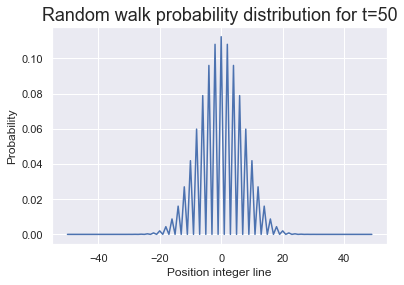

In [93]:
# Generate the time evolution of the probability distribution of a random walk for 300 time steps and an integer line 
# ranging from -50 to 50.
random_prob()

Therefore, it seems reasonable that for continuous time the equation that describes a unidimensional random walk is: 

$$S_{t} = S_{t-1} + \epsilon_{t}$$

where **$\epsilon_t$ is the difference between past and present prices (residuals)** and is random.

We usually call **$\epsilon_t$ white noise** and satisfies the following properties: 

- It is **normally distributed** with $\mu$, $\sigma$ remaining constant.
- It has **no autocorrelation**.

Then, we can define a random walk as a time series where values tend to persist over time and the difference between periods is white noise.  

We can confirm that white noise has no autocorrelation with AutoCorrelation Function (ACF) from statsmodels. For white noise with same mean and variance as S&P500:

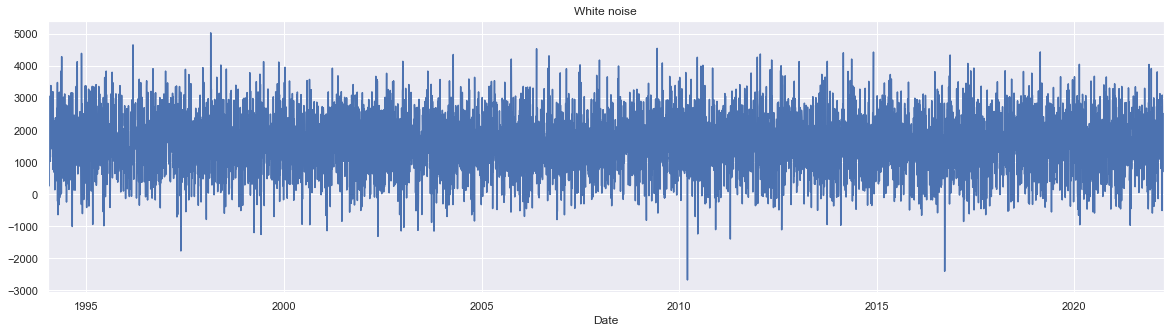

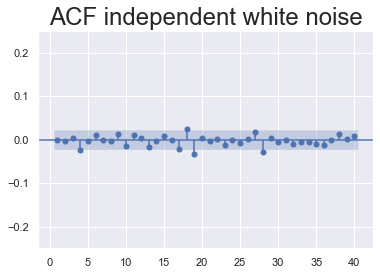

In [8]:
wn = np.random.normal(loc = df_comp.sp500.mean(), scale = df_comp.sp500.std(), size = len(df_comp.sp500))
df_comp['wn'] = wn
df_comp.wn.plot(title = 'White noise', figsize = (20,5))
sgt.plot_acf(df_comp.wn, lags = 40, zero = False)
plt.ylim(-0.25,0.25)
plt.title('ACF independent white noise', size = 24)
plt.show()

It is then shown that white noise has no significant autocorrelation considering the forty previous periods. Note that the blue shadow informs about the significance range. What about market prices? 

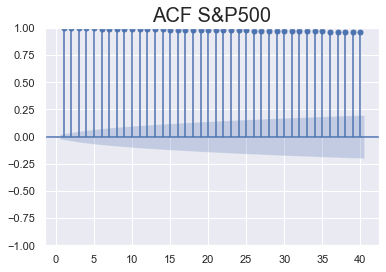

In [9]:
sgt.plot_acf(df_comp.sp500, lags = 40, zero = False)
plt.title('ACF S&P500', size = 20)
plt.show()

Here autocorrelation is evident. It seems that the closer a past period is to the current period, the higher the correlation. However, this might be misleading since market prices are generated on top of past prices. Therefore, autocorrelation is inevitable, by construction. On the other hand, white noise points are independent identically distributed random variables. See what happens if we concatenate them:  

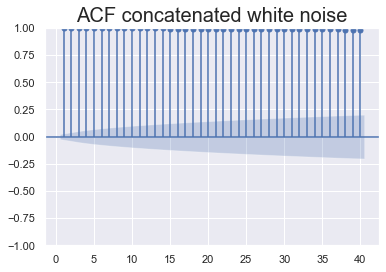

In [96]:
for i in range(len(wn)-1):
    wn[i+1] = wn[i+1] + wn[i]
sgt.plot_acf(wn, lags = 40, zero = False)
plt.title('ACF concatenated white noise', size = 20)
plt.show()

Therefore, we need another function for determining correlation appropiately: Partial AutoCorrelation Function (PACF). While **ACF includes direct and indirect effects of past periods to the present one, PACF only considers direct effects**. In other words, both methods compute $corr(S_t,S_{t-k})$ but only PACF discounts $corr(S_t,S_{t-1}),corr(S_t,S_{t-2}),...,corr(S_t,S_{t-k+1})$ to $corr(S_t,S_{t-k})$ calculation.

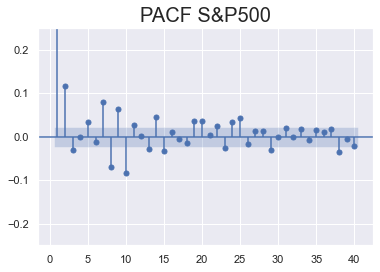

In [10]:
sgt.plot_pacf(df_comp.sp500, lags = 40, zero = False, method = ('ols'))
plt.ylim(-0.25,0.25)
plt.title('PACF S&P500', size = 20)
plt.show()

PACF shows us that most of the influence of past prices in present price is due to yesterday price. In other words, modelling **stock prices** as **Markov stochastic process** might be reasonable.

#### How realistic is the assumption of considering stock prices behave as a random walk?

In the plot below there are three prices generated from an unidimensional random walk and one real price. Could you guess which corresponds to a stock index?

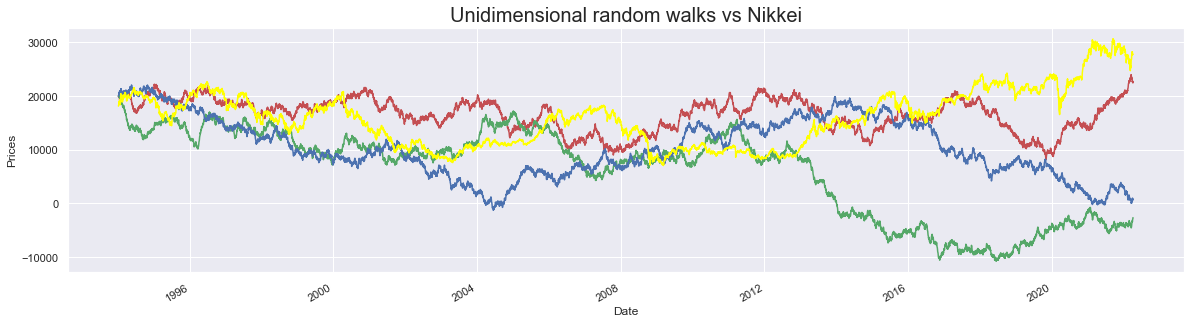

In [12]:
dates = df_comp.index

rw1 = randomwalk1D(dates)
rw2 = randomwalk1D(dates)
rw3 = randomwalk1D(dates)

df_comp['rw'] = rw1

plt.plot(dates, rw1, 'r-', label="rw1")
plt.plot(dates, rw2, 'g-', label="rw2")
plt.plot(dates, rw3, 'b-', label="rw3")
plt.ylabel('Prices')
df_comp.nikkei.plot(color = 'yellow', figsize = (20,5))
plt.title('Unidimensional random walks vs Nikkei', size = 20)
plt.show()

The yellow trajectory is the Nikkei. Qualitatively, **random walks and market prices seem to behave similarly**. Both systems are **non-stationary**. Strictly, all data of a stationary time series should follow the same probability distribution. However, as this condition is very restrictive, **first-order covariance stationarity** is usually taken as the benchmark for assessing stationarity. Hence, stationary time series meet the following points:

- $\mu$ constant 
- $cov(S_n ,S_{n+k}) = cov(S_m, S_{m+k})$

As $cov(S_n ,S_{n+k}) = corr(S_m ,S_{m+k})\sigma_n \sigma_m$ **white noise is a stationary stochastic process**. 

**Non-stationary stochastic processes tend to show seasonality and tendencies** in their corresponding time series. In fact, **if markets were always  completely efficient**, they would be completely unpredictable and **would behave as a random walk**. **Inefficiencies are what allow us to find hidden patterns so we can make predictions in the short term**.  

All in all, random walks seem to capture quite well the nature of market behaviour.

#### How do we assess if a time series is stationary or not? 

We can use examine our time series with the **Dickey-Fuller test**. For us, it is important to know how to interpret the test results. Its null hypotesis is: this time series is non-stationary. Therefore, if its **p-value is lower than 0.05 we can infer that our time series is stationary**(null hypothesis rejection). 

In [39]:
print('Dickey-fuller test p-value for FTSE: {}'.format(sts.adfuller(df_comp.ftse)[1]))
print('Dickey-fuller test p-value for S&P500: {}'.format(sts.adfuller(df_comp.sp500)[1]))
print('Dickey-fuller test p-value for Nikkei: {}'.format(sts.adfuller(df_comp.nikkei)[1]))
print('Dickey-fuller test p-value for DAX: {}'.format(sts.adfuller(df_comp.dax)[1]))
print('Dickey-fuller test p-value for random walk: {}'.format(sts.adfuller(df_comp.rw)[1]))
print('Dickey-fuller test p-value for white noise: {}'.format(sts.adfuller(df_comp.wn)[1]))

Dickey-fuller test p-value for FTSE: 0.2765210724505107
Dickey-fuller test p-value for S&P500: 0.9988143357452193
Dickey-fuller test p-value for Nikkei: 0.7520505659432446
Dickey-fuller test p-value for DAX: 0.8573025778241573
Dickey-fuller test p-value for random walk: 0.9904294972143104
Dickey-fuller test p-value for white noise: 0.0


#### Why are we so interested in stationary data?  

Suppose we have a data set $X_1,...,X_n$. The most basic assumption is that $X_i$ are independent, i.e. we have a sample. Independence is a nice property, since using it we can derive a lot of useful results. The problem is that sometimes this property does not hold.

Now independence is a unique property, two random variables can be independent only in one way, but they can be dependent in various ways. **Stationarity is one way of modeling the dependence structure**. It turns out that a lot of **results** which hold for **independent random variables** (law of large numbers and central limit theorem, for example) **hold for stationary random variables**, too (we should strictly say sequences).

On the other hand, there is **Wold's decomposition theorem** which says that every **covariance-stationary time series** $ Y_{t}$ can be written as the **sum of two time series, one deterministic and one stochastic**. Formally, 

$$Y_t = \sum_{i=1}^{\infty}b_i\epsilon_{t-i} + \eta_t$$

where $\epsilon_t$ is a white noise process and $\eta_t$ is a deterministic time series. 

This theorem can be considered as an **existence theorem: any stationary process has this seemingly special representation**. However, when we propose a **model for a time series, we substitute $\epsilon_t$ by $y_t \equiv r_t - \mu $**, which is the error term (**residual**). Therefore, **if** we fit a model and its **residuals resemble white noise, we have missed no patterns**. The usefulness of Wold's Theorem is that it allows the dynamic evolution of a variable to be approximated by a linear model.

Luckily, many non-stationary time series become stationary with simple transformations. In our case, **returns are stationary**. 

$$r_t = \frac{S_t-S_{t-1}}{S_{t-1}}·100 $$


|                     | Stationary time series | Non-stationary time series |   
|---------------------|------------------------|----------------------------|
|**Stats properties** | Independent of time    |Function of time            |   
|**Mean**             | Constant               |Function of time            |  
|**Reversion to mean**|        Yes             |         No                 |    
|**Trend/seasonality**|        No              |         Yes                |




In [13]:
#compute returns 
df_comp['ret_sp500'] = df_comp.sp500.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

Note that we have lost one value. 

In [14]:
print('Dickey-fuller test p-value for FTSE returns: {}'.format(sts.adfuller(df_comp.ret_ftse[1:])[1]))
print('Dickey-fuller test p-value for S&P500 returns: {}'.format(sts.adfuller(df_comp.ret_sp500[1:])[1]))
print('Dickey-fuller test p-value for Nikkei returns: {}'.format(sts.adfuller(df_comp.ret_nikkei[1:])[1]))
print('Dickey-fuller test p-value for DAX returns: {}'.format(sts.adfuller(df_comp.ret_dax[1:])[1]))

Dickey-fuller test p-value for FTSE returns: 3.163985633590182e-29
Dickey-fuller test p-value for S&P500 returns: 1.1433376762109608e-27
Dickey-fuller test p-value for Nikkei returns: 0.0
Dickey-fuller test p-value for DAX returns: 0.0


#### How realistic is the assumption of considering returns behave as a random walk?

Recall that random walk probability distribution resembles a normal. Now we want to confirm that returns are also gaussian. To asses that we use a qq plot: **the better the red line fits returns distribution, the more similar returns distribution is to a normal distribution**.

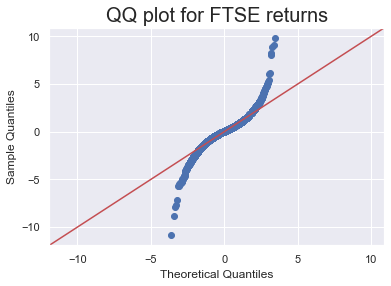

In [15]:
sm.qqplot(df_comp.ret_ftse, line='45')
plt.title('QQ plot for FTSE returns', size = 20)
pylab.show()

### 1.5 Splitting data 

In order to **avoid overfitting and validate our model adjustment**, we need to split data between training and testing sets. In this case, we take the 90% of data as the training set and the remaining as the test set. 

In [16]:
size = int(len(df_comp)*0.90)
df_train, df_test = df_comp.iloc[:size], df_comp[size:]

## 2. Relevant models

### 2.1 Models for predicting returns 

#### 2.1.2 AutoRegressive (AR)

In order to predict the present value, it takes a constant baseline and considers **past values** of the time series. Then an AR of order p, AR(p): 

$$r_t = C + \sum_{i=1}^{p}\phi_ir_{t-i} + y_t$$

where $C$ and $\phi_i$ are constants that are **fitted to training data using least squares method for minimizing $y_t$**. 

We need that $-1<C<1$ and $-1<\phi<1$ hold to avoid series divergence. As **stationary processes show reversion to the mean** $\phi_i r_{t-i} < 0$, since in completely efficient markets $\mu \rightarrow 0$.

We can use PACF to determine a reasonable number of lags. 

#### 2.1.3 Moving Average (MA)

In order to predict the present value, it takes a constant baseline and considers **past residuals** of the time series. Then a MA(q): 

$$r_t = C + \sum_{i=1}^{q}\theta_i\epsilon_{t-i} + y_t $$

Again, $|\theta_i| < 1$ and might be useful to use ACF to determine an appropiate number of lags. 

#### 2.1.4 AutoRegressive Moving Average (ARMA)

It takes into account **past values and residuals**. Then an ARMA(p,q): 

$$r_t = C + \sum_{i=1}^{p}\phi_ir_{t-i} + \sum_{i=1}^{q}\theta_i y_{t-i} + y_t $$

To determine a reasonable number of lags we can check whether residuals resemble white noise or not. 

#### 2.1.5 AutoRegressive Integrated Moving Average (ARIMA)

This model let deal with **non-stationary data** since it integrates data until it becomes stationary. Essentially, by data **integration** we mean **taking increments of prices**, for example. For instance, computing **returns** from prices is equivalent to integrating prices one time. A second integration would require computing returns increments, and so on. Then, an ARIMA(p,d=1,q) for prices: 

$$\Delta S_t = C + \sum_{i=1}^{p}\phi_i\Delta S_{t-i} + \sum_{i=1}^{q}\theta_i y_{t-i} + y_t $$

where $\Delta S_t = S_t - S_{t-1}$

Repeated integration has three general issues: 

- For each integration we lose one data point. 
- For several integrations the margin between statistical significance and insignificance narrows. This can prevent models from converging or even cause numerical instability.
- The larger the number of integrations, the more difficult it is to interpret results. 

#### 2.1.6 ARIMAX 

Apart from statistical dependencies and properties, in real markets we need to consider **external factors** such as interest rates or commodities price. Then we can add a term containing time series for exogeneous variables: 

$$\Delta S_t = C + \sum_{i=1}^{p}\phi_i\Delta S_{t-i} + \sum_{i=1}^{q}\theta_i y_{t-i} + y_t + \sum_{i=1}^{k}\beta_iX_{t-k}$$

Note that **$X_i$ can be any variable** we are interested in: a time varying measurement, categorical or even boolean variables. 

#### 2.1.7 SARIMAX

It is possible that stationary data presents **stational patterns**. These can be taken into account indicating the length of the cycle to the model. Then, a SARIMAX has **two times the orders**, in comparison to previous models: $(p,d,q)(P,D,Q,m)$ where $m$ is the lenght of the cycle and $P,D,Q$ are ARIMA orders for the seasonal pattern. For example, a SARIMAX(1,0,2)(2,0,1,5) would be: 

$$r_t = C + \phi_1r_{t-1} + \theta_1 y_{t-1} + \theta_2\epsilon_{t-2} + \Phi_1(r_{t-5} + \phi_1r_{t-6}) + \Phi_2(r_{t-10} + \phi_1r_{t-11}) + \Theta_1( y_{t-5} + \theta_1 y_{t-6} + \theta_2 y_{t-7}) + y_t $$

### 2.2 Models for predicting volatility

Despite all previous models it is very difficult to forecast future returns due to the number of factors that affect markets. Consequently, many investors seek stability rather than attractive returns, since they always carry risk. We can understand **volatility as the magnitude of $\epsilon_t$**. As we are looking for stability, we do not care about the sign. Furthermore, squaring values yields two benefits: 

- Penalizes heavier high differences between true values and predictions 
- Increases the importance of big unprecedented shocks

#### 2.1.1 AutoRegressive Conditional Heteroskedasticity (ARCH)

In order to estimate volatility, ARCH takes into account **residual past values**: 

$$ \sigma_{t}^{2} = \alpha_0 + \sum_{i=1}^{p}\alpha_i y_{t-i}^{2} \quad where \quad  r_t = \mu_t + y_t $$

where $\alpha_0 > 0$ and $\alpha_i \geq 0$. Note that $\mu_t$ can be considered described by a SARIMAX model, for example. However, we will **consider $\mu_t$ as a constant value**. 

**ARCH model assumes $y_t = \sigma_t\epsilon_t$**. Again, in accurate fits the error term will statistically resemble white noise. Note that **ARCH variance estimator is a generalization of the standard variance estimator**: 

$$\alpha_0 = 0, \alpha_i = \frac{1}{p-1} \quad \rightarrow \quad \sigma_{t}^{2} =  \frac{1}{p-1}\sum_{i=1}^{p} y_{t-i}^{2} = \frac{1}{p-1}\sum_{i=1}^{p} (r_i - \mu)^2 = \frac{1}{p-1}\sum_{i=1}^{p} (r_i - \overline{r})^2 $$

Nevertheless, looking at market returns we realise that **volatility shows clustering**. That is, periods of high volatility tend to be followed by  high volatility periods, and viceversa. Are you capable of determining which events caused that volatility spikes?

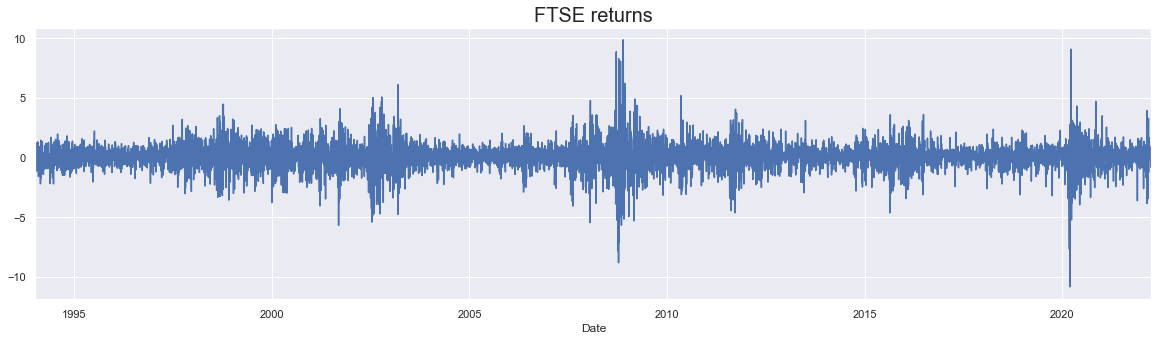

In [17]:
df_comp.ret_ftse.plot(figsize = (20,5))
plt.title('FTSE returns', size = 20)
plt.show()

#### 2.2.2 Generalized AutoRegeressive Conditonal Heteroskedasticity (GARCH)

According to volatility clustering, it seems including **past variances** might enhance model performance. That is what GARCH(p,q) does: 

$$ \sigma_{t}^{2} = \omega + \sum_{i=1}^{p}\alpha_i y_{t-i}^{2} + \sum_{j=1}^{q}\beta_j \sigma_{j-i}^{2}  $$ 

where $\omega$ is a baseline constant to deviate from.

### 3. Model selection criteria 

Model selection is more an art than science, but some good practices are established. It is generally considered good practice to find the smallest values of $p$ and $q$ which provide an acceptable fit to the data. What do we mean with 'acceptable fit'? We can use different statistical parameters to assess goodness of fit:

- **Log-likelihood**: Among statisticians, there is no consensus about what the foundation of statistics should be. There are four main paradigms that have been proposed for the foundation: frequentism, Bayesianism, likelihoodism and AIC-based. However, they all agree that **the higher the likelihood, the better the fit**. 

- **Information criteria**: The most usual ones are Bayesian Information Criteria (**BIC**) and Akaike's Information Criteria (**AIC**). In both cases, **the lower the information, the better the fit**.

- **Residual analysis**: As markets are supposed to behave as random walks, **residuals should be similar to white noise distributed data**

- **Coefficient analysis**: in order to avoid overfitting and too complex models, coefficients should be **significantly different from zero**. 

Model selection and comparison might be very time-consuming and tedious. Luckily, `auto_arima()` function gives us the best model according to the criteria above. On the other hand, **GARCH(1,1) is the best model for estimating volatility**, since more complex models do not outperform it significantly. As markets are Markovian, **all the relevant information contained in past lags is incorporated in the previous lag**. 

### 4. Model fitting 

Let us show you how to fit models using Python libraries.

#### 4.1 ARMA(1,1)

In order to show to fit models manually, statsmodels library is very useful.

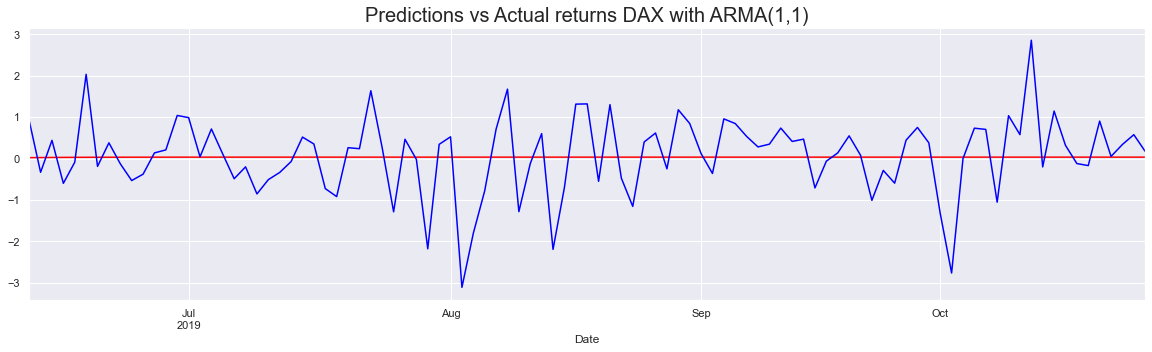

In [202]:
#choose model 
model_ret_arma = sm.tsa.arima.ARIMA(df_train.ret_dax[1:], order = (1,0,1))
#fit model to training data
results_ret_arma = model_ret_arma.fit()
#make predictions
pred_arma = results_ret_arma.predict(start = df_test.dax.index[0], end = '2022-04-05')

pred_arma[1:100].plot(figsize = (20,5), color = 'red')

df_test.ret_dax[1:100].plot(color = 'blue')
plt.title('Predictions vs Actual returns DAX with ARMA(1,1)', size = 20)
plt.show()

In [203]:
results_ret_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ret_dax   No. Observations:                 6630
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -11687.464
Date:                Mon, 30 May 2022   AIC                          23382.929
Time:                        18:42:49   BIC                          23410.126
Sample:                    01-10-1994   HQIC                         23392.326
                         - 06-07-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0355      0.017      2.089      0.037       0.002       0.069
ar.L1          0.7772      0.091      8.567      0.000       0.599       0.955
ma.L1         -0.7995      0.086     -9.279      0.000      -0.968      -0.631
sigma2         1.9892      0.019    104.015      0.000       1.952       2.027
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):              6233.16
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As you can see, our fit is quite bad. Alternatively, you can try to improve those results with higher-order ARMA models.

#### 4.2 Automating model selection with auto_arima()

The fastest way to find the ideal SARIMAX model for our data is using `auto_arima()`. We should simply set the **maximum order and provide exogeonous data and the lenght of the cycle, m, if needed**.

In [173]:
model_auto = auto_arima(df_train.ret_dax[1:], 
                        exogenous = df_train[['ret_sp500','ret_ftse','ret_nikkei']][1:],
                        m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

# auto_arima method yields a np.array instead of a dataframe
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[:]),
                            exogenous = df_test[['ret_sp500','ret_ftse','ret_nikkei']][:]), 
                            index = df_test[:].index)

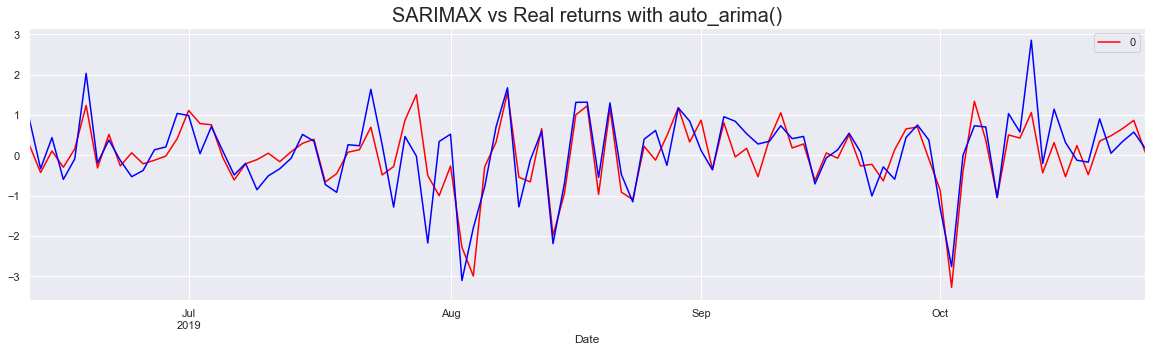

In [204]:
df_auto_pred[1:100].plot(figsize = (20,5), color = 'red')
df_test.ret_dax[1:100].plot(color = 'blue', figsize = (20,5))
plt.title('SARIMAX vs Real returns with auto_arima()', size = 20)
plt.show()

In [194]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6630
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -8088.052
Date:                Mon, 30 May 2022   AIC                          16186.104
Time:                        17:55:41   BIC                          16220.101
Sample:                    01-10-1994   HQIC                         16197.851
                         - 06-07-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ret_sp500      0.2739      0.006     47.306      0.000       0.263       0.285
ret_ftse       0.8566      0.006    131.900      0.000       0.844       0.869
ret_nikkei     0.0349      0.006      6.230      0.000       0.024       0.046
ma.L1         -0.0768      0.008     -9.702      0.000      -0.092      -0.061
sigma2         0.6716      0.006    104.013      0.000       0.659       0.684
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8103.11
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Although the fitting seems quite decent, it depends heaviliy on exogenous data. That means that **SARIMAX can only be used for in-sample predictions**, rather than out-of-sample forecast. **If we want to forecast the future**, there are two approaches: 

**i) Forecast future values for exogenous variables** using multivariate regeressions, for instance.

**ii) Forecast volatility**, rather than returns.

#### 4.2 Estimating volatility 

In the Binomial model, **volatility** is the only parameter that is not accessible. Therefore, **we have to estimate it from market data**. Now we want to make in-sample predictions. Given the variance for day one, we predict the variance for the following day using GARCH(1,1). Thus, only the first computation is derived directly from market data, while the consecutive predictions take into account how far the prediction is from real data ($y_t$ term).

In [18]:
df_train.ret_ftse.tail()

Date
2019-06-03    0.322544
2019-06-04    0.410589
2019-06-05    0.081787
2019-06-06    0.549842
2019-06-07    0.991749
Freq: B, Name: ret_ftse, dtype: float64

In [19]:
start_date = '2008-01-01'
end_date = '2008-12-31'
mod_garch = arch_model(df_train.ret_sp500[1:], vol = 'GARCH', p = 1, q = 1, mean = 'constant', dist = 'Normal')
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     62,   Neg. LLF: 4797.440149538777
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4797.440120887928
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12


As we want **to apply** this daily volatility data to our **binomial model, we need to annualize volatility**. From the Central Limit Theorem: 

$$\sigma_{\overline{x}} = \frac{\sigma_x}{\sqrt{n}} \quad \rightarrow \quad \sigma_{annualized} = \frac{\sigma_{daily}}{\sqrt{252}} $$

where $n=252$ because there are 252 trading days in a year, on average.

In [20]:
# horizon: how many observations we want our model to predict for each date

# align: target, we match the value with the date it is supposed to represent,
#instead of the day the prediction is made

pred_garch = res_garch.forecast(horizon = 1, align = 'target')
variance = np.array(pred_garch.residual_variance[start_date:end_date])
sigma = []
for i in range(len(variance)):
     sigma.append(math.sqrt(variance[i]*252)/100)

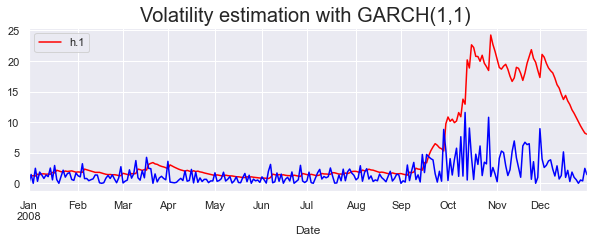

In [21]:
pred_garch.residual_variance[start_date:end_date].plot(figsize = (10,3), color = 'red')
df_comp.ret_sp500.abs()[start_date:end_date].plot(color = 'blue')
plt.title('Volatility estimation with GARCH(1,1) ', size = 20)
plt.show()

Recall that on September 15, 2008, Lehman Brothers declared its bankruptcy and the worst financial crisis in a century started. That is the reason why volatility rised so much in that moment.

#### 4.3 Forecasting volatility

Now we forecast volatility a hundred days away starting from the first day of the test set. Besides, we visualize how this compares with real returns.

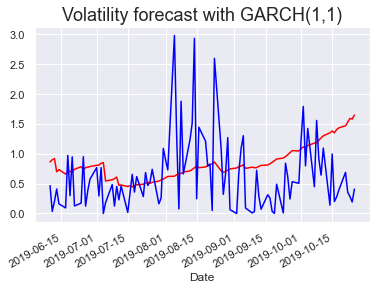

In [22]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')

#start from the last day of the training set
forecast_vol = pred_garch.residual_variance[-1:]
forecast_vol = forecast_vol.iloc[0]


plt.plot(df_test.ret_sp500.index[0:100],forecast_vol, color = 'red')
df_test.ret_sp500.abs()[0:100].plot(color = 'blue')
plt.title('Volatility forecast with GARCH(1,1)', size = 18)
plt.show()

### 5. Application to the binomial model

We use the data obtanied from estimating volatility in 4.2 and evaluate how it affects a European Call premium. Note that when using daily volatility data, $T$ and $N$ should be chosen so that $dt = 1$ day.

In [23]:
T = 1
N = 252
S0 = 60 
r = 0.01 
K = 70 
opttype1 = 'e'
opttype2 = 'c'

binomial_model(T,N,S0, sigma, r, K,opttype1,opttype2)
print('The fair price of your {} {} option is:'.format(opttype1,opttype2), option[0][0])


The fair price of your e c option is: 11.047611277684876


In [24]:
T = 1
N = 252
S0 = 60 
r = 0.01 
K = 70 
sigma = 0.6
opttype1 = 'e'
opttype2 = 'c'

binomial_model_constant_vol(T,N,S0, sigma, r, K,opttype1,opttype2)
print('The fair price of your {} {} option is:'.format(opttype1,opttype2), option[0][0])

The fair price of your e c option is: 11.007866620384497


Note that we need an annual constant volatility of 60% to repoduce the premium obtained annualizing daily volatility estimated with GARCH(1,1). Thus, we conclude that **assuming a constant volatility is a very bad approximation**. On the contrary, assuming a constant risk-free interest rate (if option's maturity is up to a year) might be a better approximation since it tends to vary in a larger time scale, comparatively.